In [2]:
# Importing Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import numpy as np

In [3]:
data= pd.read_csv("C:/Users/aashi/Downloads/complaints_25Nov21.csv")

In [20]:
# Set your X (predictor) and y (predicted) variables
selected_features = ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',
                     'Company response to consumer', 'Timely response?']
X = data[selected_features]
X.fillna('unknown', inplace = True)
le = LabelEncoder()
y = le.fit_transform(data['Consumer disputed?'])

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=selected_features)

# Split the data into a test and train set (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=123)

# Calculate the proportion of consumers who raised a dispute in the test set
proportion_disputed_test = sum(y_test) / len(y_test)
print("Proportion of consumers who raised a dispute in the test set: {:.2f}%".format(proportion_disputed_test * 100))

C:\Users\aashi\AppData\Local\Temp\ipykernel_3816\2915480030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna('unknown', inplace = True)


Proportion of consumers who raised a dispute in the test set: 21.59%


In [5]:
# Find the number of samples in the minority class (disputed complaints)
minority_class_size = np.sum(y_train == 1)

# Perform undersampling manually
# First, find the indices of the majority and minority classes
majority_class_indices = np.where(y_train == 0)[0]
minority_class_indices = np.where(y_train == 1)[0]

# Now randomly sample from the majority class to get a sample size equal to the minority class size
np.random.seed(123)  # Set the random seed for reproducibility
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_size,
                                           replace=False)

# Combine the majority and minority class indices after undersampling
undersampled_indices = np.concatenate([minority_class_indices, random_majority_indices])

# Slice the training data to get the balanced dataset
X_train_balanced = X_train.iloc[undersampled_indices]
y_train_balanced = y_train[undersampled_indices]

# Calculate the proportion of disputes in the balanced training set
dispute_proportion_training_balanced = y_train_balanced.mean()
dispute_proportion_training_balanced

0.5

In [13]:
# Define a function to calculate the cost of dealing with a complaint
def calculate_complaint_cost(complaint_row):
    # Replace this with your logic to calculate the cost
    # Example: if a complaint is costly and you have a cost associated with it
    if complaint_row['Consumer disputed?'] == 'Yes':
        return 600  # Replace 100 with the actual cost
    else:
        return 100  # Replace 50 with the actual cost for other complaints

# Apply the function to each complaint in the test set
test_set = data.sample(frac=0.2, random_state=123)  # Assuming a 20% test set split
test_set['Complaint Cost'] = test_set.apply(calculate_complaint_cost, axis=1)

# Calculate the total cost
cost_without_model = test_set['Complaint Cost'].sum()

print(f"Estimated total cost without a model : ${cost_without_model:.2f}")

Estimated total cost without a model : $8619200.00


In [21]:
# Train a predictive model using XGBoost Classifier
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train, y_train)

# Evaluate the model on the test set and calculate recall
y_pred = model_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     32504
           1       0.49      0.00      0.01      8948

    accuracy                           0.78     41452
   macro avg       0.64      0.50      0.44     41452
weighted avg       0.72      0.78      0.69     41452



[[32463    41]
 [ 8909    39]]
Total cost to the banks of dealing with the complaints in the test set: $8606900


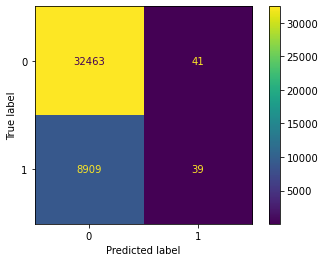

In [24]:
# Define cost structure
base_cost = 100  # Initial cost for every complaint
extra_diligence_cost = 90  # Cost for extra diligence
disputed_cost = 600  # Cost if a complaint is disputed

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate total cost
true_positives, false_positives, false_negatives, true_negatives  = confusion.ravel()

total_cost = (
    ((true_negatives + false_positives) * (base_cost + extra_diligence_cost)) +  # Non-disputed complaints
    (false_negatives * (disputed_cost)) +  # Predicted disputes with extra diligence
    (true_positives * base_cost)  # Predicted disputes without extra diligence
)

print(confusion)
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test)

print(f"Total cost to the banks of dealing with the complaints in the test set: ${total_cost}")

In [25]:
# Initialize variables to keep track of the best threshold and lowest cost
best_threshold = 0
lowest_cost = float('inf')

# Iterate through different threshold values
for threshold in np.linspace(0, 1, 101):  # Adjust the range and granularity as needed
    # Make predictions on the test set
    y_prob = model_xgb.predict_proba(X_test)
    # We drop the probabilities for class 0, and keep just the second column
    y_prob = y_prob[:,1]
    y_pred = (y_prob >= threshold).astype(int)  # Predict using the threshold

    # Calculate the confusion matrix
    confusion = confusion_matrix(y_test, y_pred)

    # Calculate total cost
    tn, fp, fn, tp = confusion.ravel()
    total_cost = ((tn*100) + ((tp+fp)*(100+90)) + (fn*600))

    # Check if this threshold results in a lower cost
    if total_cost < lowest_cost:
        lowest_cost = total_cost
        best_threshold = threshold

print(f"Best threshold for the lowest total cost: {best_threshold}")
print(f"Lowest total cost: ${lowest_cost}")

Best threshold for the lowest total cost: 0.17
Lowest total cost: $7596570
